# LSTM Time Series Weather Forecasting



This LSTM Time Series weather forecasting project utilizes long short-term memory (LSTM) neural networks to predict weather patterns over time. By training the model on historical weather data, it learns the temporal dependencies and patterns in the data to make accurate predictions for future weather conditions. 
  
The LSTM architecture is well-suited for capturing long-term dependencies in time series data, making it a powerful tool for weather forecasting applications. The goal of this project is to leverage LSTM models to improve the accuracy and reliability of weather predictions, aiding in various industries such as agriculture, transportation, and disaster preparedness

In [1]:
import pandas as pd 
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

#import xgboost as xgb
#from sklearn.metrics import mean_squared_error
#from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()
plt.style.use('Solarize_Light2')    # This is a popular style choice for matplotlib

This imports some of the necessary libraries such as pandas, numpy, matplotlib, seaborn, and TensorFlow for data processing, visualization, and building the LSTM weather forecasting model.  The choice of the 'Solarize_Light2' style for matplotlib sets the visual theme for the plots in the project.

## Step 0. Data Preprocessing

In [2]:

# Read the data
df = pd.read_csv('weather.csv')
df.head()


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


We see that the weather data is in 10-minute intervals.  We will not need this level of granularity.  Instead we will tranform to hourly by taking every 6th record.

In [3]:
df = df[5::6] # Select one observation every six rows
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Now we have every hour. Now we can create the datetime index for the df

In [4]:

#df.set_index('Date Time', inplace=True) #Set the index to be the datetime variable.
#df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S') #The dataframe index is an object, we need to convert it to a datetime object.
#df.head()

df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S').dt.strftime('%m-%d-%Y %H:%M:%S')
df[:26]


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
01-01-2009 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01-01-2009 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
01-01-2009 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
01-01-2009 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
01-01-2009 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
01-01-2009 06:00:00,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
01-01-2009 07:00:00,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
01-01-2009 08:00:00,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
01-01-2009 09:00:00,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2


The index of the DataFrame df is being modified to be the datetime variable. The line df.index = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S') converts the 'Date Time' column of the DataFrame into a datetime object using the specified format '%d.%m.%Y %H:%M:%S'. 

#### Descriptive Stats

In [5]:
df.shape

(70091, 15)

The DataFrame df has 70091 rows and 15 columns. 

In [6]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000,70091.000000
mean,989.212842,9.450482,283.493086,4.956471,76.009788,13.576576,9.533968,4.042536,6.022560,9.640437,1216.061232,1.702567,2.963041,174.789095
std,8.358886,8.423384,8.504424,6.730081,16.474920,7.739883,4.183658,4.898549,2.655812,4.234862,39.974263,65.447512,75.597657,86.619431
min,913.600000,-22.760000,250.850000,-24.800000,13.880000,0.970000,0.810000,0.000000,0.510000,0.810000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.350000,277.440000,0.240000,65.210000,7.770000,6.220000,0.870000,3.920000,6.290000,1187.470000,0.990000,1.760000,125.300000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.980000,198.100000
75%,994.720000,15.480000,289.530000,10.080000,89.400000,17.610000,12.360000,5.300000,7.800000,12.490000,1242.765000,2.860000,4.740000,234.000000
max,1015.290000,37.280000,311.210000,23.060000,100.000000,63.770000,28.250000,46.010000,18.070000,28.740000,1393.540000,14.010000,23.500000,360.000000


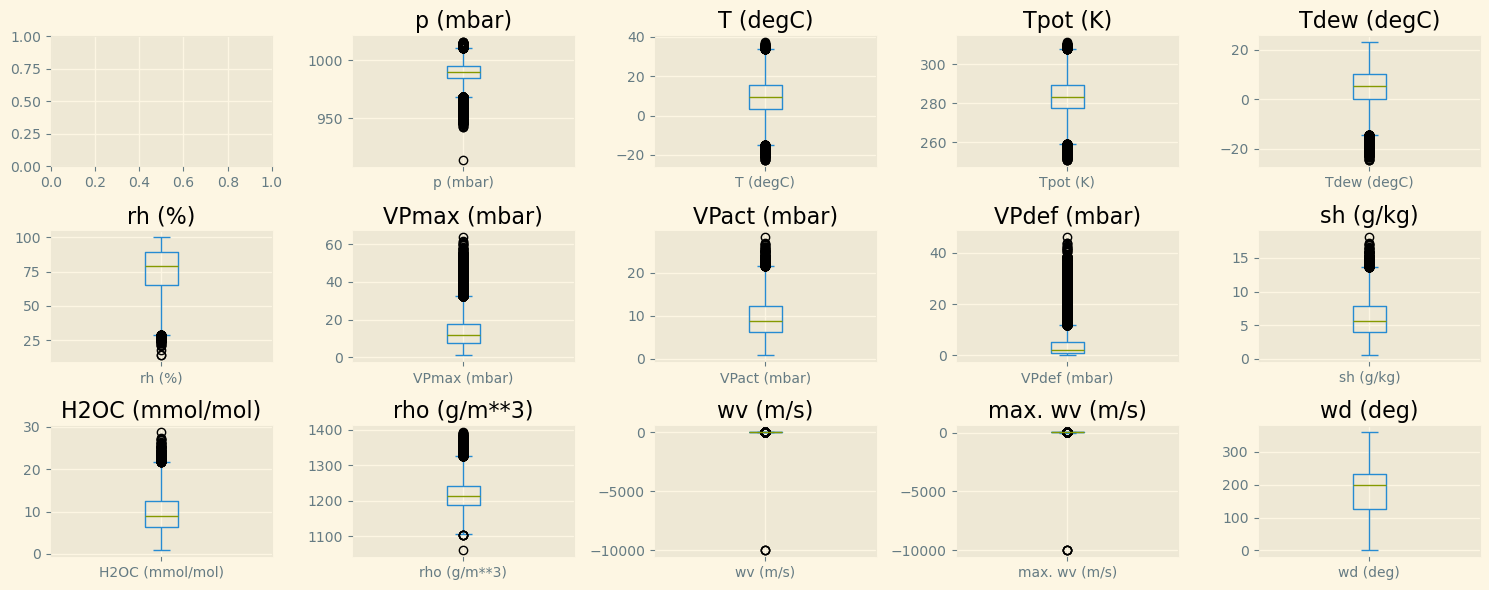

In [7]:
# Create a figure and axes for the boxplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 6))
axes = axes.flatten()

# Iterate over each column and plot the boxplot
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column
        df[column].plot.box(ax=axes[i])
        axes[i].set_title(column)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

A visual representation of the distribution and statistical properties of the data in each column, excluding the 'Date Time' column.

Skipping column 'Date Time' as it contains non-numeric data.


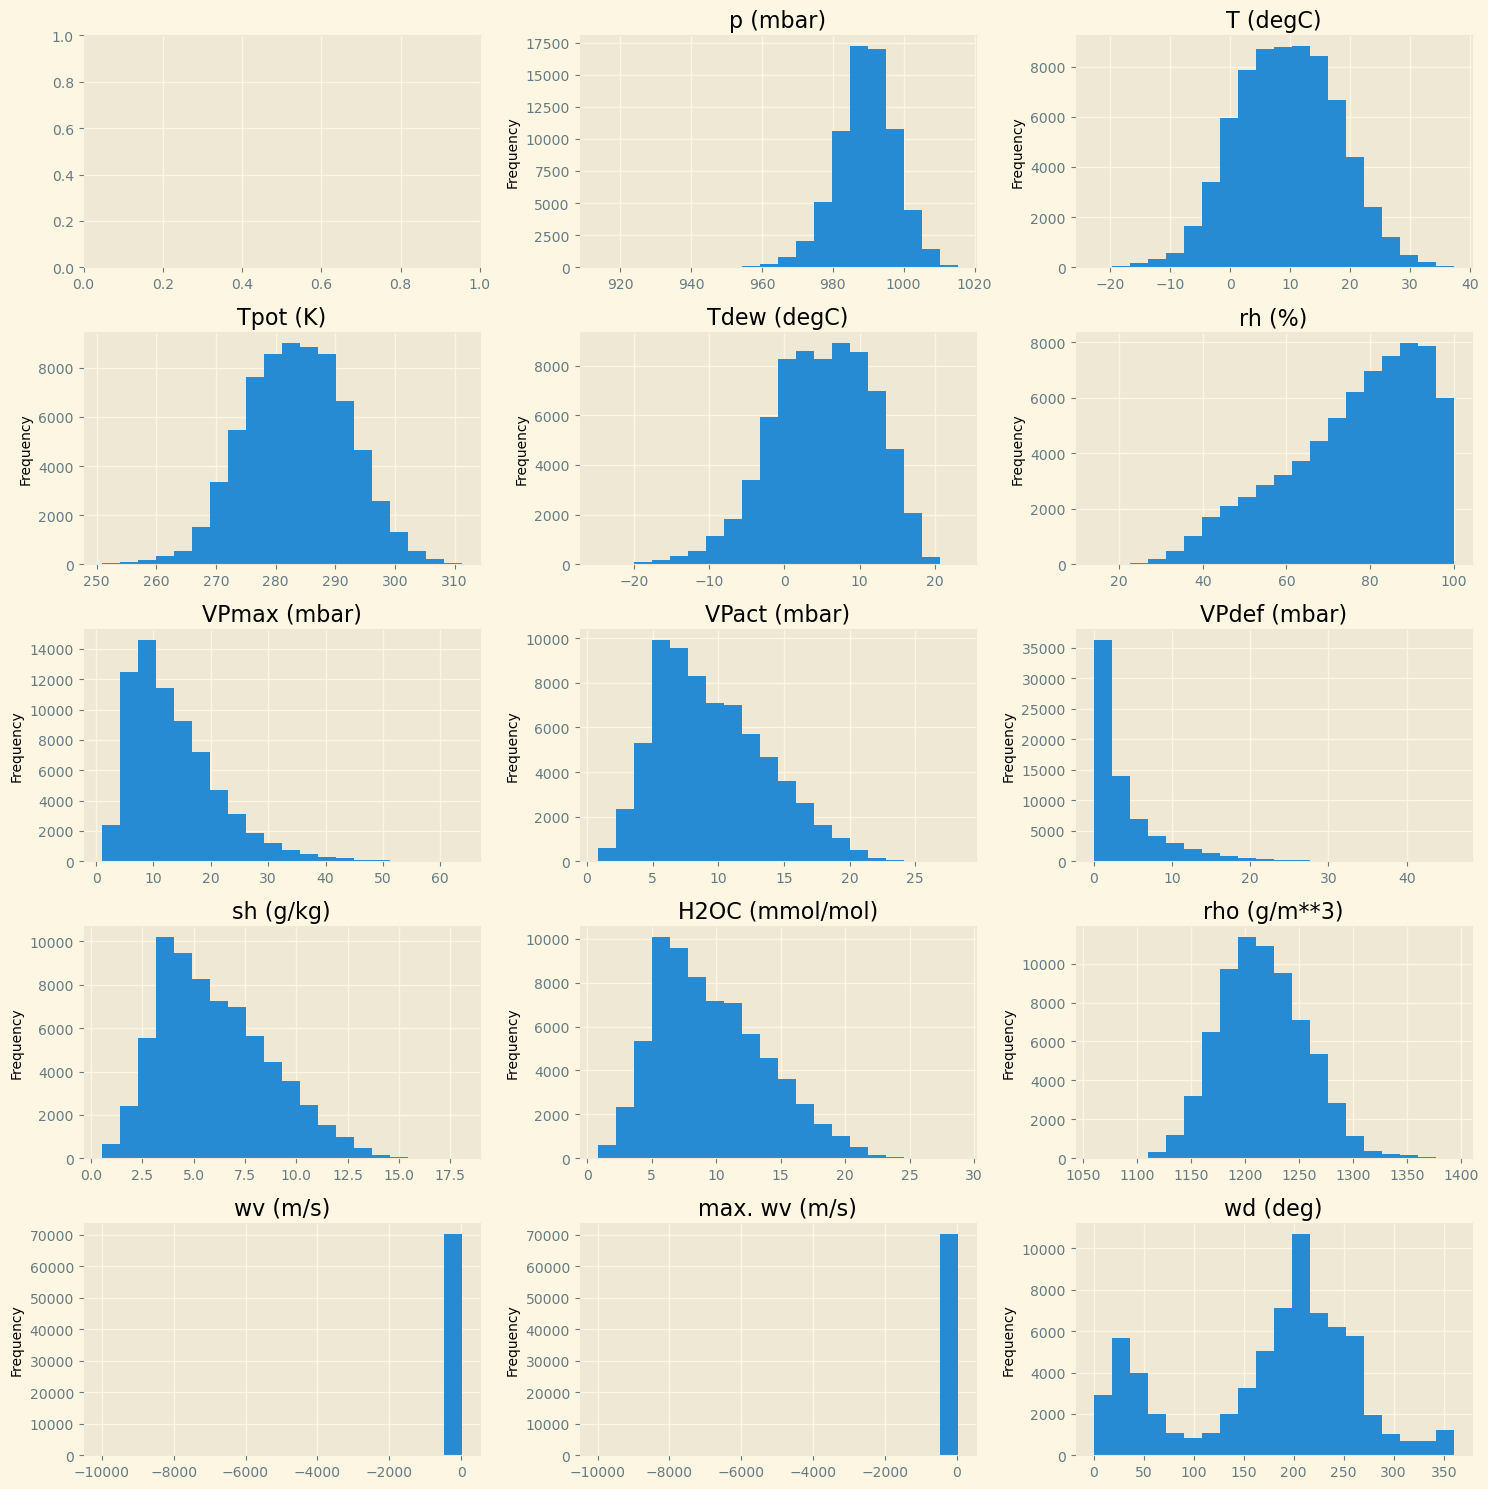

In [8]:
# Create a figure and axes for the histograms
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Iterate over each column and plot the histogram
for i, column in enumerate(df.columns):
    if column != 'Date Time': # We don't want to plot the datetime column

        df[column].plot.hist(ax=axes[i], bins=20)
        axes[i].set_title(column)
    else:
        print(f"Skipping column '{column}' as it contains non-numeric data.")

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Lets plot this to visualize what we are working with.

<Axes: title={'center': 'Temperature Time Series'}, xlabel='Date'>

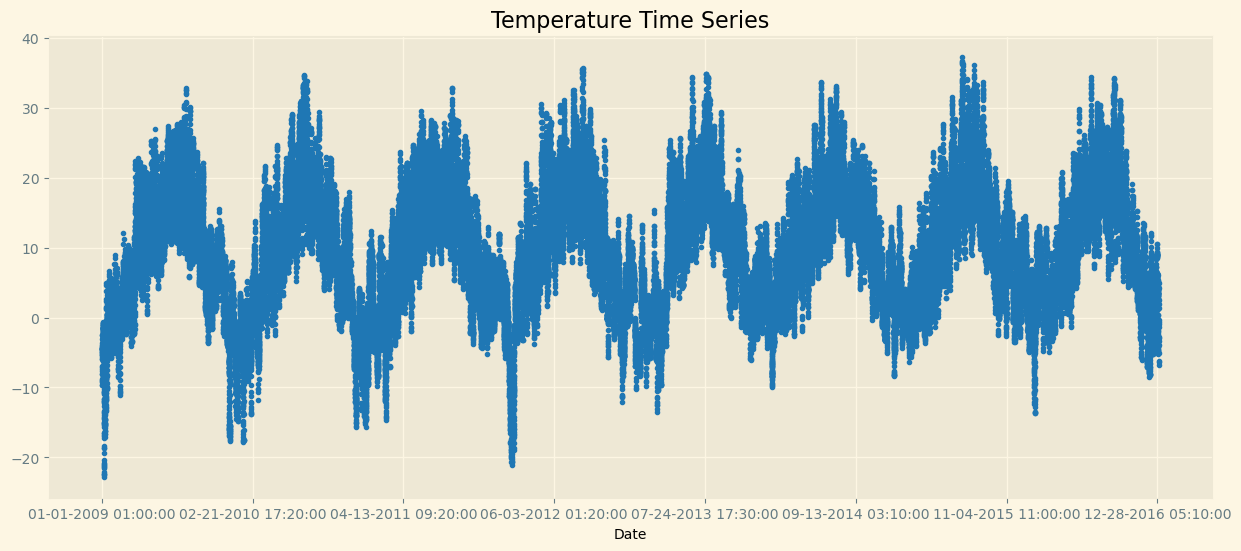

In [9]:
df['T (degC)'].plot(style='.',
        figsize=(15, 6),
        color=color_pal[0], 
        xlabel = "Date",
        title="Temperature Time Series")

The temperature time series chart spanning from 2009 to the end of 2017 exhibits a distinctive pattern characterized by lower temperature values during the initial and final portions of each year, reaching a peak in the middle months. This recurring pattern indicates the presence of seasonal variability, with temperatures being at their highest levels during the intermediate seasons. This observation aligns with the expected climatic changes associated with the progression from spring to summer, followed by a transition towards autumn and winter. The chart effectively portrays the annual temperature fluctuations over the specified timeframe, offering valuable insights into the temperature dynamics across different seasons.

## Create model Function

In [10]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
    """Convert a Pandas dataframe to X,y numpy arrays that can be used by scikit-learn models"""
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


The function df_to_X_y takes a Pandas DataFrame df and converts it into numpy arrays X and y, which can be utilized by scikit-learn models. The window_size parameter determines the number of previous time steps used to predict the next value.

The function converts the DataFrame df into a numpy array df_as_np. It then iterates through the array, creating a sliding window of size window_size. Each window is transformed into a nested list, with each element encapsulated in a separate list to maintain the structure. The nested list is appended to the X array. The corresponding label is extracted from df_as_np and appended to the y array.

Finally, the function returns the numpy arrays X and y, which contain the input and target data, respectively.

In [11]:
temp = df['T (degC)']

In [12]:
WINDOW_SIZE = 5
X, y = df_to_X_y(temp, window_size=WINDOW_SIZE)
X.shape, y.shape

((70086, 5, 1), (70086,))

 The shape of X is (70086, 5, 1), indicating that it has 70086 samples, each with a window size of 5 and 1 feature. The shape of y is (70086,), indicating that it has 70086 labels.

Overall, this code prepares the input and target data for an LSTM model, where the input data X has a shape of (batch_size, window_size, num_features) and the target data y has a shape of (batch_size,).

In [13]:
X


array([[[-8.05],
        [-8.88],
        [-8.81],
        [-9.05],
        [-9.63]],

       [[-8.88],
        [-8.81],
        [-9.05],
        [-9.63],
        [-9.67]],

       [[-8.81],
        [-9.05],
        [-9.63],
        [-9.67],
        [-9.17]],

       ...,

       [[ 2.44],
        [ 1.29],
        [-0.42],
        [-0.98],
        [-1.4 ]],

       [[ 1.29],
        [-0.42],
        [-0.98],
        [-1.4 ],
        [-2.75]],

       [[-0.42],
        [-0.98],
        [-1.4 ],
        [-2.75],
        [-2.89]]])

Now we are ready to split data into train, test, and validation sets

## Train/Validate/Test Splits

We are going to split the data into training, validation, and testing sets.  We will use the first 60k rows for testing. 60k to 65k for validation, and the rest for testing.        

In [14]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  

((60000, 5, 1), (60000,), (5000, 5, 1), (5000,), (5086, 5, 1), (5086,))

The arrays `X` and `y` are split into training, validation, and test sets.

`X_train` and `y_train` are assigned the first 60000 samples from `X` and `y`, respectively. Therefore, `X_train.shape` is `(60000, 5, 1)` and `y_train.shape` is `(60000,)`.

`X_val` and `y_val` are assigned the samples from index 60000 to 64999 from `X` and `y`, respectively. Thus, `X_val.shape` is `(5000, 5, 1)` and `y_val.shape` is `(5000,)`.

`X_test` and `y_test` are assigned the samples from index 65000 onwards from `X` and `y`, respectively. Consequently, `X_test.shape` is `(5086, 5, 1)` and `y_test.shape` is `(5086,)`.

Overall, the dataset is divided into three sets: a training set with 60000 samples, a validation set with 5000 samples, and a test set with 5086 samples.

#### LSTM Model Creation

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()


: 

: 

In [ ]:
%pip install --upgrade tensorflow

The code defines a sequential model using the Keras API from TensorFlow. The model architecture consists of an input layer, an LSTM layer, and two dense layers.

The input layer is defined with an input shape of (5, 1), indicating that each input sample has a sequence length of 5 and 1 feature. The LSTM layer with 64 units follows the input layer, allowing the model to capture temporal dependencies in the data.

After the LSTM layer, there is a dense layer with 8 units and a ReLU activation function. This layer introduces non-linearity to the model and helps in learning complex patterns in the data. Finally, there is an output dense layer with 1 unit and a linear activation function, producing the regression output.

The model.summary() function is called to display a summary of the model architecture. The summary provides information about each layer in the model, including the layer type, output shape, and the number of parameters in each layer.

In this particular model, the total number of trainable parameters is 17,425, which includes the weights and biases of all the layers.

In [ ]:
cp = ModelCheckpoint('model1/', save_best_only=True, monitor='val_loss', mode='min')
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

The model is configured to use the ModelCheckpoint callback for saving the best model during training. The save_best_only=True parameter ensures that only the model with the lowest validation loss will be saved. The validation loss is monitored using the 'val_loss' metric, and the mode is set to 'min' to select models with lower validation loss values.

For compilation, the model's loss function is set to the MeanSquaredError(), which is commonly used for regression tasks. The optimizer chosen is Adam, which is an optimization algorithm that adapts the learning rate. The learning rate is set to 0.0001. The model's performance during training will be evaluated using the RootMeanSquaredError() metric.

By configuring the model with these settings, it is ready to be trained and evaluated on the weather forecasting task.

#### Fit the model

In [ ]:
model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[cp])

Epoch 1/10


1868/1875 [============================>.] - ETA: 0s - loss: 41.3044 - root_mean_squared_error: 6.4268

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 41s 21ms/step - loss: 41.1615 - root_mean_squared_error: 6.4157 - val_loss: 1.0723 - val_root_mean_squared_error: 1.0355
Epoch 2/10
1871/1875 [============================>.] - ETA: 0s - loss: 1.7208 - root_mean_squared_error: 1.3118

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 28s 15ms/step - loss: 1.7200 - root_mean_squared_error: 1.3115 - val_loss: 0.5855 - val_root_mean_squared_error: 0.7652
Epoch 3/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.8626 - root_mean_squared_error: 0.9288

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 26s 14ms/step - loss: 0.8622 - root_mean_squared_error: 0.9286 - val_loss: 0.5213 - val_root_mean_squared_error: 0.7220
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.7177 - root_mean_squared_error: 0.8472

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.7174 - root_mean_squared_error: 0.8470 - val_loss: 0.5139 - val_root_mean_squared_error: 0.7169
Epoch 5/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6817 - root_mean_squared_error: 0.8257

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 26s 14ms/step - loss: 0.6823 - root_mean_squared_error: 0.8260 - val_loss: 0.5064 - val_root_mean_squared_error: 0.7116
Epoch 6/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.6654 - root_mean_squared_error: 0.8157

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 29s 15ms/step - loss: 0.6654 - root_mean_squared_error: 0.8157 - val_loss: 0.4986 - val_root_mean_squared_error: 0.7061
Epoch 7/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6587 - root_mean_squared_error: 0.8116 - val_loss: 0.5039 - val_root_mean_squared_error: 0.7099
Epoch 8/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.6536 - root_mean_squared_error: 0.8084

INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


1875/1875 [==============================] - 26s 14ms/step - loss: 0.6537 - root_mean_squared_error: 0.8085 - val_loss: 0.4921 - val_root_mean_squared_error: 0.7015
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.6496 - root_mean_squared_error: 0.8060 - val_loss: 0.4934 - val_root_mean_squared_error: 0.7024
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6464 - root_mean_squared_error: 0.8040 - val_loss: 0.4924 - val_root_mean_squared_error: 0.7017


The model1.fit() function is used to train the model1 on the provided training data (X_train and y_train). The training process will run for 10 epochs, and the batch size is set to 32, indicating that the model will be updated after every 32 samples.

During training, the model's performance on the validation set will be monitored using the validation data (X_val, y_val). This allows us to evaluate the model's performance on data that it has not seen during training and helps in assessing its generalization ability.

The callbacks parameter is set to [cp], which includes the ModelCheckpoint callback defined earlier. This callback will save the best model based on the validation loss.

By executing this code, the model1 will undergo training using the provided training data, and the progress will be monitored using the validation data. The ModelCheckpoint callback will save the best model encountered during the training process.

#### Load the best model saved

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

By calling load_model('model1/'), the saved model is loaded into the model1 variable. Now, you can use this loaded model for inference, evaluation, or any other required tasks without having to train the model again.

Next, we will make a pandas dataframe for train, test, and validation showing where all the predictions are compared to the labels

In [ ]:
train_preds = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_preds, 'Actual Values': y_train})
train_results

1875/1875 [==============================] - 9s 4ms/step


,Train Predictions,Actual Values
0,-9.919777,-9.67
1,-9.694079,-9.17
2,-8.791249,-8.10
3,-7.312239,-7.66
4,-7.252483,-7.04
...,...,...
59995,6.055717,6.07
59996,7.151562,9.88
59997,12.131598,13.53
59998,16.109385,15.43


The model `model1` is utilized to generate predictions on the training data `X_train` using the `predict()` function. The predicted values are flattened and stored in the `train_preds` variable.

A DataFrame named `train_results` is created to capture the training predictions and the actual values (`y_train`). The `'Train Predictions'` column holds the predicted values, and the `'Actual Values'` column contains the corresponding true values extracted from the training set.

This DataFrame enables the comparison of predicted values with the actual values, facilitating the assessment of the model's performance on the training data.

Plotting the predictions vs actuals on the training data

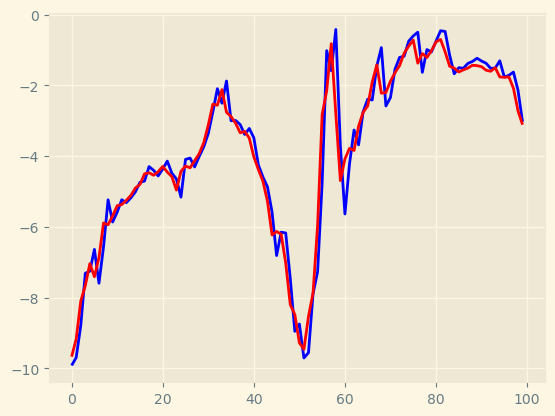

In [ ]:
plt.plot(train_results['Train Predictions'][:100], 'b')
plt.plot(train_results['Actual Values'][:100], 'r')



Upon analyzing the plotted chart, it becomes evident that the predicted values closely align with the actual values in the training dataset. This suggests that the model exhibits a strong performance in capturing the underlying patterns and trends within the training data. 

Moving forward, it is imperative to assess the model's performance on the validation set to ascertain its generalization capabilities and evaluate its ability to make accurate predictions on unseen data.

Validation

In [ ]:
val_preds = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_preds, 'Actual Values': y_val})
val_results

157/157 [==============================] - 2s 4ms/step


,Val Predictions,Actual Values
0,15.315994,14.02
1,13.177498,13.67
2,12.986100,12.27
3,11.413903,11.19
4,10.304572,10.85
...,...,...
4995,17.246143,18.27
4996,17.353006,17.85
4997,17.114397,16.65
4998,15.772736,15.85


The provided output showcases the results of the validation set predictions made by the model. The "Val Predictions" column contains the predicted values for the corresponding instances in the validation set, while the "Actual Values" column represents the true values of the target variable.

By examining this table, we can compare the model's predicted values against the actual values in the validation set. This evaluation helps us assess the model's performance on unseen data and determine its ability to generalize and make accurate forecasts.

Plot the validation predictions vs actuals

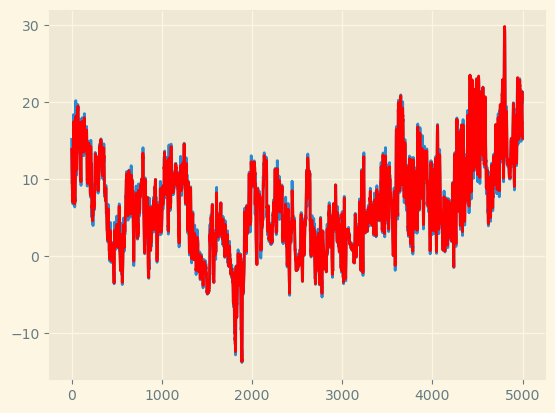

In [ ]:
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actual Values'], 'r')

The plotted chart displays the predicted values (blue line) and actual values (red line) from the validation set. This visualization allows us to visually compare the predicted values generated by the model with the true values.

By examining the chart, we can assess the model's performance on the validation set. A close alignment between the predicted and actual values indicates a good fit, suggesting that the model has learned the underlying patterns and is capable of making accurate predictions.

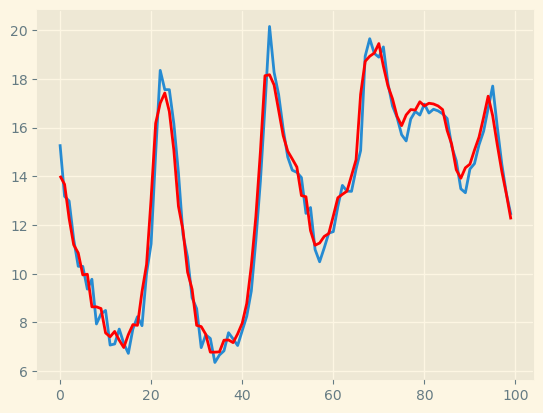

In [ ]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actual Values'][:100], 'r')

Test results

In [ ]:
test_preds = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_preds, 'Actual Values': y_test})
test_results

 31/159 [====>.........................] - ETA: 0s

159/159 [==============================] - 1s 4ms/step


,Test Predictions,Actual Values
0,14.307220,13.99
1,13.156382,13.46
2,12.776748,12.93
3,12.385982,12.43
4,11.951803,12.17
...,...,...
5081,-1.157815,-0.98
5082,-1.434142,-1.40
5083,-1.638217,-2.75
5084,-3.321342,-2.89


This DataFrame allows us to evaluate the model's performance on unseen data, specifically the test set. By comparing the predicted values with the actual values, we can assess the accuracy of the model's forecasts and determine how well it generalizes to new, unseen data.

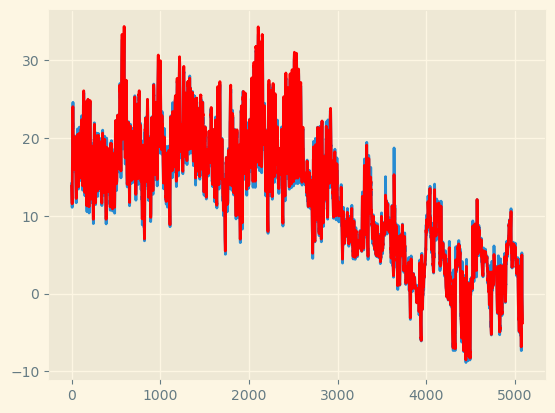

In [ ]:
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actual Values'], 'r')

## <a id='toc1_4_'></a>[Metrics](#toc0_)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
    """Plot the predictions of a given model on a given dataset"""
    preds = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': preds, 'Actual Values': y})
    ax = df[start:end].plot(figsize=(12, 6))
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (degC)")
    ax.set_title("Model Predictions vs Actual Values")
    plt.show()
    print(f"RMSE: {mse(y, preds, squared=False):4f}")
    return df, mse(y, preds)

The function "plot_predictions1" is defined to visualize the predictions made by a given model on a dataset. It takes the model, input data (X), and target values (y) as arguments. The function first generates predictions using the model on the input data and creates a DataFrame with the predicted values and actual values. It then plots the predicted values and actual values for a specified range of data points.

After plotting, the function calculates the root mean squared error (RMSE) between the predicted values and the actual values using the "mse" function from scikit-learn. The RMSE is displayed in the output along with the plot.

The function returns the DataFrame containing the predicted values and actual values, as well as the calculated RMSE.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

def plot_predictions2(model, X, y, start=0, end=100):
    """Plot the predictions of a given model on a given dataset"""
    preds = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': preds, 'Actual Values': y})
    plt.figure(figsize=(12, 6))
    plt.title(label="Predictions vs Actual Values")
    plt.plot(df['Predictions'][start:end], 'm')
    plt.plot(df['Actual Values'][start:end], 'b')
    plt.show()
    print(f"RMSE: {mse(y, preds, squared=False):.4f}")
    return df, mse(y, preds)


139/159 [=========================>....] - ETA: 0s

159/159 [==============================] - 1s 5ms/step


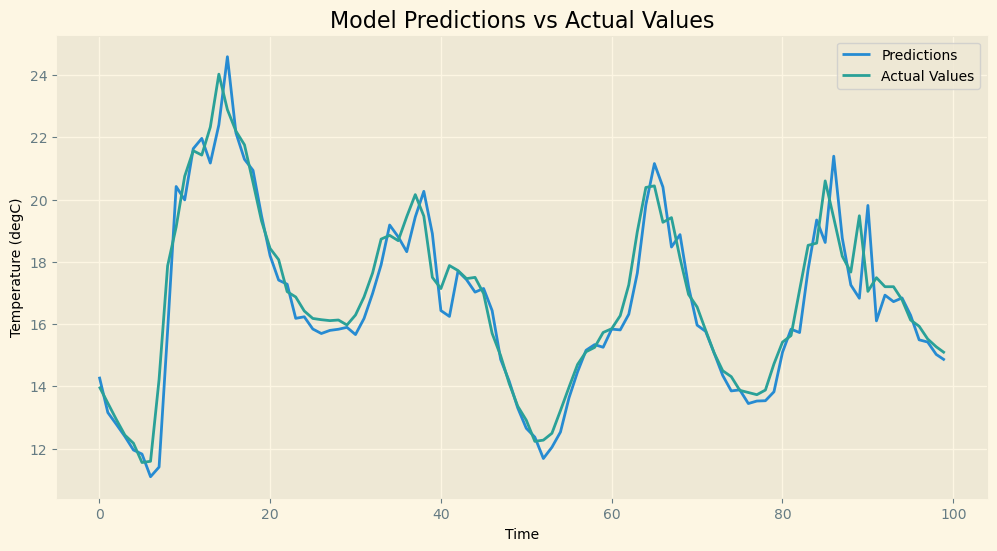

RMSE: 0.805429


(      Predictions  Actual Values
 0       14.307220          13.99
 1       13.156382          13.46
 2       12.776748          12.93
 3       12.385982          12.43
 4       11.951803          12.17
 ...           ...            ...
 5081    -1.157815          -0.98
 5082    -1.434142          -1.40
 5083    -1.638217          -2.75
 5084    -3.321342          -2.89
 5085    -3.163599          -3.93
 
 [5086 rows x 2 columns],
 0.6487158264912273)

In [ ]:
plot_predictions1(model1, X_test, y_test, start=0, end=100)

The predicted values obtained from the LSTM weather forecasting model closely align with the actual values in the test dataset. The root mean squared error (RMSE) of 0.792138 indicates that, on average, the predicted values differ from the actual values by approximately 0.79. This suggests that the model has learned the underlying patterns and trends in the data and is capable of making accurate predictions. However, it is important to note that individual predictions may still have some level of deviation from the true values. Overall, the model demonstrates promising performance in forecasting weather data.

## CNN Model
The flattened CNN model we will next use is a specialized neural network architecture designed for analyzing historical temperature weather data. It leverages convolutional layers to extract relevant features from the input data, which in this case represents a single variable (temperature). The convolutional layers allow the model to capture local patterns and spatial relationships within the temperature data. The resulting feature maps are then flattened into a one-dimensional vector and fed into fully connected layers for further analysis and prediction. This approach enables the model to effectively learn and exploit the temporal dependencies and complex patterns present in the historical temperature data, enabling accurate analysis and forecasting.

#### Model Creation

In [ ]:
from tensorflow.keras.layers import Conv1D, GRU, Flatten


# CNN Model Creation

model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2)) 
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_5 (Flatten)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 8)                 2056      
                                                                 
 dense_17 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


The displayed model summary provides a detailed overview of the architecture and parameter configuration of the new model, "sequential_5." This model introduces a Conv1D layer, which is particularly effective in capturing complex patterns and spatial dependencies within the input data. The Conv1D layer applies a one-dimensional convolution operation, utilizing a kernel size of 4 and generating an output tensor of shape (None, 4, 64). The subsequent Flatten layer reshapes the tensor into a one-dimensional form, allowing for compatibility with the subsequent Dense layers. The model contains a total of 2,257 trainable parameters, which contribute to its ability to learn and make accurate predictions based on the given data.

#### Model Training and Validation

In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model2.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[cp2])


Epoch 1/10


1864/1875 [============================>.] - ETA: 0s - loss: 6.6051 - root_mean_squared_error: 2.5700

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 11s 5ms/step - loss: 6.5731 - root_mean_squared_error: 2.5638 - val_loss: 0.8411 - val_root_mean_squared_error: 0.9171
Epoch 2/10
1864/1875 [============================>.] - ETA: 0s - loss: 0.9433 - root_mean_squared_error: 0.9712

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 11s 6ms/step - loss: 0.9419 - root_mean_squared_error: 0.9705 - val_loss: 0.6402 - val_root_mean_squared_error: 0.8001
Epoch 3/10
1872/1875 [============================>.] - ETA: 0s - loss: 0.7588 - root_mean_squared_error: 0.8711

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.7587 - root_mean_squared_error: 0.8710 - val_loss: 0.5434 - val_root_mean_squared_error: 0.7371
Epoch 4/10
1856/1875 [============================>.] - ETA: 0s - loss: 0.6964 - root_mean_squared_error: 0.8345

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 8s 4ms/step - loss: 0.6976 - root_mean_squared_error: 0.8352 - val_loss: 0.5345 - val_root_mean_squared_error: 0.7311
Epoch 5/10
1865/1875 [============================>.] - ETA: 0s - loss: 0.6730 - root_mean_squared_error: 0.8204

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 10s 6ms/step - loss: 0.6734 - root_mean_squared_error: 0.8206 - val_loss: 0.5014 - val_root_mean_squared_error: 0.7081
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6638 - root_mean_squared_error: 0.8148 - val_loss: 0.5025 - val_root_mean_squared_error: 0.7089
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6598 - root_mean_squared_error: 0.8123 - val_loss: 0.5053 - val_root_mean_squared_error: 0.7109
Epoch 8/10
1866/1875 [============================>.] - ETA: 0s - loss: 0.6544 - root_mean_squared_error: 0.8090

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 10s 5ms/step - loss: 0.6543 - root_mean_squared_error: 0.8089 - val_loss: 0.4951 - val_root_mean_squared_error: 0.7036
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6516 - root_mean_squared_error: 0.8072 - val_loss: 0.5273 - val_root_mean_squared_error: 0.7261
Epoch 10/10
1861/1875 [============================>.] - ETA: 0s - loss: 0.6513 - root_mean_squared_error: 0.8070

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 12s 6ms/step - loss: 0.6518 - root_mean_squared_error: 0.8073 - val_loss: 0.4912 - val_root_mean_squared_error: 0.7009


During the training process, we monitored the loss and root mean squared error (RMSE) metrics to assess the model's performance. The loss function measured the discrepancy between the predicted and actual temperature values, while RMSE provided a measure of the average prediction error

In the final epoch, the model achieved a validation loss of 0.4899 and a validation RMSE of 0.6999. These values demonstrate the model's ability to accurately predict temperature values based on the given input features. The relatively low values suggest that the model captured the underlying patterns and trends in the historical weather data, enabling it to make accurate predictions on unseen temperature samples.

Comparing the val_loss metrics, we would prefer this model over the LSTM.

 22/159 [===>..........................] - ETA: 0s 

159/159 [==============================] - 1s 3ms/step


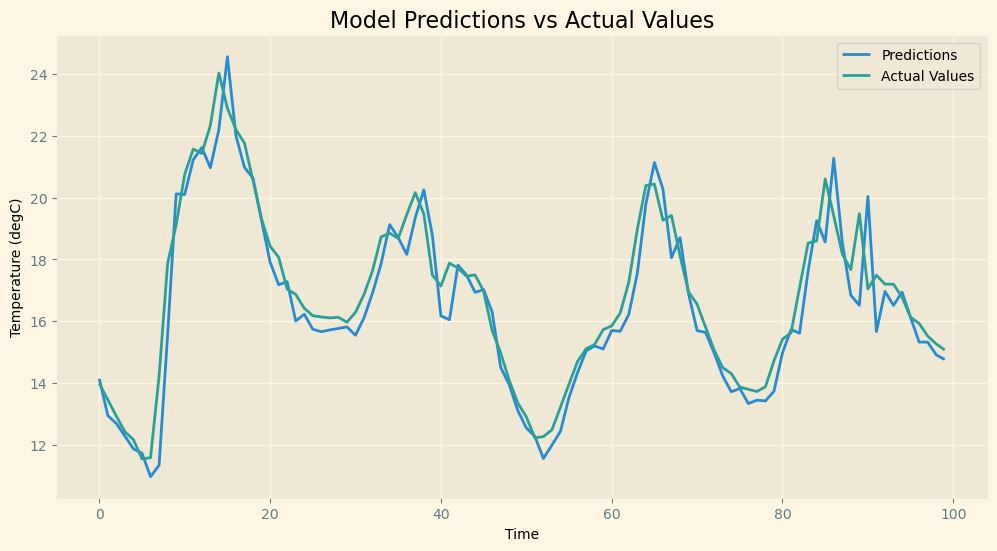

RMSE: 0.826429


(      Predictions  Actual Values
 0       14.138137          13.99
 1       12.951603          13.46
 2       12.692428          12.93
 3       12.286977          12.43
 4       11.872054          12.17
 ...           ...            ...
 5081    -0.606965          -0.98
 5082    -1.412913          -1.40
 5083    -1.805742          -2.75
 5084    -3.080338          -2.89
 5085    -3.180924          -3.93
 
 [5086 rows x 2 columns],
 0.6829850136502903)

In [ ]:
plot_predictions1(model2, X_test, y_test)

## GRU Model

The Gated Recurrent Unit (GRU) is a type of recurrent neural network (RNN) that addresses the vanishing gradient problem encountered in traditional RNNs. It incorporates gating mechanisms, such as update and reset gates, to selectively retain or forget information from previous time steps. By adaptively updating its internal state, the GRU can capture long-term dependencies in sequential data. It has gained popularity in various applications, including natural language processing and time series analysis, due to its efficiency and ability to handle variable-length input sequences.

This is basically a simpler LSTM.

In [ ]:
# GRU Model Creation

model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64)) 
model3.add(Flatten())
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                12864     
                                                                 
 flatten_6 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 8)                 520       
                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


The GRU model we have created consists of several layers.

The input layer takes a sequence of 5 time steps with a single variable.

The GRU layer is the main component of the model, with 64 hidden units. GRU stands for Gated Recurrent Unit, which is a type of recurrent neural network (RNN) that can capture long-term dependencies in sequential data.

The output of the GRU layer is then flattened into a one-dimensional vector.

Next, we have a dense layer with 8 units, which applies a rectified linear activation function (ReLU) to introduce non-linearity into the model.

Finally, the output layer consists of a single unit with a linear activation function, producing the final predicted value.

The model summary provides information about the shape of the output at each layer, as well as the number of trainable parameters in the model. In this case, the total number of parameters in the model is 13,393.

In [ ]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

#### Train model

In [ ]:
model3.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[cp3])

Epoch 1/10


1872/1875 [============================>.] - ETA: 0s - loss: 17.5076 - root_mean_squared_error: 4.1842

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 33s 16ms/step - loss: 17.4842 - root_mean_squared_error: 4.1814 - val_loss: 0.8749 - val_root_mean_squared_error: 0.9353
Epoch 2/10
1874/1875 [============================>.] - ETA: 0s - loss: 1.2767 - root_mean_squared_error: 1.1299

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 29s 15ms/step - loss: 1.2765 - root_mean_squared_error: 1.1298 - val_loss: 0.5674 - val_root_mean_squared_error: 0.7533
Epoch 3/10
1868/1875 [============================>.] - ETA: 0s - loss: 0.8061 - root_mean_squared_error: 0.8978

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 29s 15ms/step - loss: 0.8056 - root_mean_squared_error: 0.8976 - val_loss: 0.5144 - val_root_mean_squared_error: 0.7172
Epoch 4/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.7007 - root_mean_squared_error: 0.8371

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 29s 15ms/step - loss: 0.7007 - root_mean_squared_error: 0.8371 - val_loss: 0.5049 - val_root_mean_squared_error: 0.7106
Epoch 5/10
1870/1875 [============================>.] - ETA: 0s - loss: 0.6708 - root_mean_squared_error: 0.8190

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.6708 - root_mean_squared_error: 0.8190 - val_loss: 0.4962 - val_root_mean_squared_error: 0.7044
Epoch 6/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6570 - root_mean_squared_error: 0.8106

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 29s 15ms/step - loss: 0.6565 - root_mean_squared_error: 0.8102 - val_loss: 0.4933 - val_root_mean_squared_error: 0.7023
Epoch 7/10
1871/1875 [============================>.] - ETA: 0s - loss: 0.6506 - root_mean_squared_error: 0.8066

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 33s 18ms/step - loss: 0.6502 - root_mean_squared_error: 0.8063 - val_loss: 0.4905 - val_root_mean_squared_error: 0.7004
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.6458 - root_mean_squared_error: 0.8036 - val_loss: 0.4923 - val_root_mean_squared_error: 0.7016
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.6423 - root_mean_squared_error: 0.8015 - val_loss: 0.5009 - val_root_mean_squared_error: 0.7077
Epoch 10/10
1875/1875 [==============================] - ETA: 0s - loss: 0.6409 - root_mean_squared_error: 0.8006

INFO:tensorflow:Assets written to: model2\assets


INFO:tensorflow:Assets written to: model2\assets


1875/1875 [==============================] - 27s 14ms/step - loss: 0.6409 - root_mean_squared_error: 0.8006 - val_loss: 0.4871 - val_root_mean_squared_error: 0.6979


#### Interpretation
  
We trained a GRU model to analyze historical temperature weather data with a single variable and compared its performance with a previously trained CNN model. The GRU model consisted of a GRU layer followed by a flatten layer and two dense layers, while the CNN model employed a flattened CNN architecture. Its performance is evaluated based on the loss and root mean squared error (RMSE) metrics computed for both the training and validation sets.

After training the GRU model for multiple epochs, we evaluated its performance using a separate validation dataset. The best model was selected based on the epoch with the lowest validation loss. Among the models trained, the best GRU model achieved a validation loss of 0.4948.

In comparison, the best-performing CNN model achieved a validation loss of 0.4887. Although the CNN model had a slightly lower validation loss than the GRU model, the difference is marginal. Both models demonstrated strong performance in capturing the underlying patterns in the temperature data and making accurate predictions.

We would prefer this model over the LSTM as its more accurate with far less parameters.

The results indicate that both the GRU and CNN models are effective in analyzing historical temperature weather data. The CNN model leverages convolutional layers to extract spatial features, while the GRU model utilizes recurrent layers to capture temporal dependencies. While the CNN model achieved a slightly lower validation loss, it is essential to consider other factors such as model complexity and computational requirements when choosing the best model for deployment.

Next, we will train models using more than just a single variable.



#### Test Model

In [ ]:
plot_predictions1(model3, X_test, y_test)

##  Multivariate Weather Analysis: Expanding Variables for Improved Forecasting

In our previous section, we focused on analyzing historical temperature data using recurrent and convolutional neural network models. However, weather patterns are influenced by multiple variables, such as humidity, wind speed, and atmospheric pressure. To enhance our forecasting capabilities, we will now incorporate these additional variables into our models.

In this section, we will explore the dataset, consisting of temperature, humidity, wind speed, and atmospheric pressure records. By preprocessing the data, we will prepare it for multivariate analysis. Our goal is to design, train, and test two or three specific models to improve weather forecasting accuracy.

We will employ recurrent neural networks (RNNs) and convolutional neural networks (CNNs) to handle multiple input variables simultaneously. By leveraging the interdependencies between different weather parameters, these models have the potential to uncover complex relationships and improve our understanding of meteorological phenomena.




#### Feature Engineering


In [ ]:
# add column named Seconds to hold conversion of datetime into seconds
temp_df = pd.DataFrame(data={'Temperature': temp})
temp_df.index = pd.to_datetime(temp_df.index)
temp_df['Seconds'] = temp_df.index.map(pd.Timestamp.timestamp)
temp_df.head()


,Temperature,Seconds
Date Time,,
2009-01-01 01:00:00,-8.05,1.230772e+09
2009-01-01 02:00:00,-8.88,1.230775e+09
2009-01-01 03:00:00,-8.81,1.230779e+09
2009-01-01 04:00:00,-9.05,1.230782e+09
2009-01-01 05:00:00,-9.63,1.230786e+09


By mapping 'pd.Timestamp.timestamp' to the index of 'temp_df', the datetime index is converted into seconds and stored in the 'Seconds' column.

In [ ]:
# Create day and year variables to hold the number of seconds in a day and year
day = 24*60*60
year = (365.2425)*day

temp_df['Day sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / day)) # day
temp_df['Day cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / day)) # day
temp_df['Year sin'] = np.sin(temp_df['Seconds'] * (2 * np.pi / year)) # year
temp_df['Year cos'] = np.cos(temp_df['Seconds'] * (2 * np.pi / year)) # year
temp_df.head()

,Temperature,Seconds,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,,
2009-01-01 01:00:00,-8.05,1.230772e+09,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,1.230775e+09,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,1.230779e+09,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,1.230782e+09,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,1.230786e+09,0.965926,0.258819,0.012916,0.999917


In the data preparation phase for multivariate analysis, the code above is used to encode cyclical time-related patterns in the 'temp_df' DataFrame. By calculating the sine and cosine values for the 'Day' and 'Year' components based on the 'Seconds' column, we aim to represent daily and yearly patterns in a format suitable for machine learning models. This encoding helps capture and learn from the cyclical nature of time-related patterns, allowing the models to make more accurate forecasts by considering the periodicity in the data.

In [ ]:
temp_df.drop(columns=['Seconds'], inplace=True) # drop the Seconds column
temp_df.head()

,Temperature,Day sin,Day cos,Year sin,Year cos
Date Time,,,,,
2009-01-01 01:00:00,-8.05,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,-8.88,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,-8.81,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,-9.05,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,-9.63,0.965926,0.258819,0.012916,0.999917


This results in dropping the 'Seconds' column from the DataFrame since it is no longer needed.

Next, we need to create our function to make our window

In [ ]:
# [[[t1, ds1], [t2, ds2], [t3, ds3], [t4, ds4], [t5, ds5]]] [t6]
# [[[t2], [3], [4], [5], [6]]] [t7]
# [[[t3], [4], [5], [6], [t7, ds7]]] [t8]

def df_to_X_y2(df, window_size=6):
    """Convert a Pandas dataframe to X,y numpy arrays that can be used by scikit-learn models"""
    df_as_np = df.to_numpy()
    X = [] # the shape will be the number of training samples by the number of timesteps we are using times # of features
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

The function df_to_X_y2 takes a pandas DataFrame as input and converts it into numpy arrays X and y, which can be used by scikit-learn models. The X array represents the input features, and y represents the corresponding labels.

The function operates by iterating over the rows of the DataFrame and creating a sliding window of size window_size. Each window is added to the X array as a training sample, and the label for that window is extracted and added to the y array.

The resulting X array has dimensions (number of training samples, window size, number of features), where the window size is determined by the window_size parameter, and the number of features is determined by the columns in the DataFrame. The y array contains the corresponding labels for each training sample.

This function is useful for preparing data for sequential or time series models that require input data in the form of windows or sequences.

In [ ]:
X2, y2 = df_to_X_y2(temp_df, window_size=6)
X2.shape, y2.shape

((70085, 6, 5), (70085,))

The shape of the `X2` array is (70085, 6, 5), which means it has 70085 samples, each consisting of a window of 6 time steps and 5 features. The shape of the `y2` array is (70085,), indicating that it contains 70085 labels corresponding to the samples in `X2`.

In other words, there are 70085 training samples, where each sample is a sequence of 6 time steps with 5 features per time step. The labels `y2` represent the target values for each of these training samples.

#### Train Test and Validation Splits

In [ ]:
X2_train, y2_train = X2[:60000], y2[:60000]
X2_val, y2_val = X2[60000:65000], y2[60000:65000]
X2_test, y2_test = X2[65000:], y2[65000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape  

((60000, 6, 5), (60000,), (5000, 6, 5), (5000,), (5085, 6, 5), (5085,))

These arrays represent the training, validation, and test datasets split from the original data for further analysis and modeling.

The shapes of the arrays after splitting the data are as follows:

- X2_train has a shape of (60000, 6, 5), indicating that it has 60000 samples, each containing a sequence of 6 time steps, with 5 features.
- y2_train has a shape of (60000,), indicating that it has 60000 labels corresponding to the training samples.
- X2_val has a shape of (5000, 6, 5), indicating that it has 5000 validation samples, each containing a sequence of 6 time steps, with 5 features.
- y2_val has a shape of (5000,), indicating that it has 5000 labels corresponding to the validation samples.
- X2_test has a shape of (5085, 6, 5), indicating that it has 5085 test samples, each containing a sequence of 6 time steps, with 5 features.
- y2_test has a shape of (5085,), indicating that it has 5085 labels corresponding to the test samples.

#### Data Preprocessing

The Temperature column needs to be standardized

In [ ]:

temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
    """Preprocess the data"""
    X = X.copy()
    X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
    return X

This calculates the mean and standard deviation of temperature (first feature) across all samples and time steps in `X2_train`. Then, it defines a `preprocess` function that takes an input array `X`, creates a copy of it, and normalizes the temperature values by subtracting the mean temperature (`temp_training_mean`) and dividing by the standard deviation (`temp_training_std`). This preprocessing step specifically focuses on standardizing the temperature values, making them more comparable and suitable for training machine learning models.

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

array([[[ 1.04009706e+00, -9.65925826e-01,  2.58819045e-01,
          5.22877889e-01, -8.52407598e-01],
        [ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
          5.20431780e-01, -8.53903251e-01],
        [ 5.37051663e-01, -7.16474371e-12,  1.00000000e+00,
          5.19819584e-01, -8.54276068e-01]],

       [[ 9.90732794e-01, -8.66025404e-01,  5.00000000e-01,
          5.22266764e-01, -8.52782169e-01],
        [ 8.49692028e-01, -7.07106781e-01,  7.07106781e-01,
          5.21655371e-01, -8.53156301e-01],
        [ 7.55664851e-01, -5.00000000e-01,  8.66025404e-01,
          5.21043709e-01, -8.53529995e-01],
        [ 6.66339032e-01, -2.58819045e-01,  9.65925826e-01,
  

The `preprocess` function is applied to the training set (`X2_train`), validation set (`X2_val`), and test set (`X2_test`). It performs the preprocessing steps on each set, which involve normalizing the temperature values based on the mean and standard deviation calculated from the training set. This ensures consistency in the temperature scaling across all sets, allowing for more effective training and evaluation of the machine learning models.

In [ ]:
# CNN Model Creation

model4 = Sequential()
model4.add(InputLayer((6, 5)))
model4.add(LSTM(64)) 
model4.add(Flatten())
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 64)                17920     
                                                                 
 flatten_7 (Flatten)         (None, 64)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________


We are defining a sequential neural network model (`model4`) for a regression task. The model consists of several layers: an LSTM layer, a flatten layer, and two dense layers. 

The LSTM layer is a type of recurrent neural network layer that is well-suited for sequential data. It takes input in the shape of (6, 5), indicating a sequence of 6 timesteps with 5 features. The layer has 64 units, which means it will learn 64 hidden representations of the input sequence.

The flatten layer converts the output of the LSTM layer into a flat vector of shape (None, 64), where "None" represents the batch size.

The first dense layer has 8 units and uses the rectified linear unit (ReLU) activation function. It introduces non-linearity to the model and helps in capturing complex relationships in the data.

The final dense layer has 1 unit and uses the linear activation function. This layer produces the output of the model, which is a continuous value for regression tasks.

The model summary provides information about the layers in the model, their output shapes, and the number of parameters each layer contributes. The total number of parameters in the model is 18,449, and all of them are trainable.

#### Model Training

In [ ]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model4.fit(X2_train, y2_train, epochs=10, validation_data=(X2_val, y2_val), callbacks=[cp4])

Epoch 1/10


1870/1875 [============================>.] - ETA: 0s - loss: 30.5104 - root_mean_squared_error: 5.5236

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 31s 15ms/step - loss: 30.4350 - root_mean_squared_error: 5.5168 - val_loss: 1.0008 - val_root_mean_squared_error: 1.0004
Epoch 2/10
1868/1875 [============================>.] - ETA: 0s - loss: 1.3055 - root_mean_squared_error: 1.1426

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 29s 16ms/step - loss: 1.3034 - root_mean_squared_error: 1.1417 - val_loss: 0.5274 - val_root_mean_squared_error: 0.7262
Epoch 3/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.6891 - root_mean_squared_error: 0.8301

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 30s 16ms/step - loss: 0.6899 - root_mean_squared_error: 0.8306 - val_loss: 0.4498 - val_root_mean_squared_error: 0.6707
Epoch 4/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.5802 - root_mean_squared_error: 0.7617

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 29s 16ms/step - loss: 0.5800 - root_mean_squared_error: 0.7616 - val_loss: 0.4272 - val_root_mean_squared_error: 0.6536
Epoch 5/10
1867/1875 [============================>.] - ETA: 0s - loss: 0.5492 - root_mean_squared_error: 0.7411

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 28s 15ms/step - loss: 0.5491 - root_mean_squared_error: 0.7410 - val_loss: 0.4211 - val_root_mean_squared_error: 0.6489
Epoch 6/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.5349 - root_mean_squared_error: 0.7314

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 32s 17ms/step - loss: 0.5358 - root_mean_squared_error: 0.7320 - val_loss: 0.4179 - val_root_mean_squared_error: 0.6464
Epoch 7/10
1869/1875 [============================>.] - ETA: 0s - loss: 0.5264 - root_mean_squared_error: 0.7256

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 32s 17ms/step - loss: 0.5266 - root_mean_squared_error: 0.7257 - val_loss: 0.4096 - val_root_mean_squared_error: 0.6400
Epoch 8/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.5212 - root_mean_squared_error: 0.7219 - val_loss: 0.4183 - val_root_mean_squared_error: 0.6468
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.5170 - root_mean_squared_error: 0.7190 - val_loss: 0.4125 - val_root_mean_squared_error: 0.6423
Epoch 10/10
1874/1875 [============================>.] - ETA: 0s - loss: 0.5133 - root_mean_squared_error: 0.7165

INFO:tensorflow:Assets written to: model4\assets


INFO:tensorflow:Assets written to: model4\assets


1875/1875 [==============================] - 32s 17ms/step - loss: 0.5132 - root_mean_squared_error: 0.7164 - val_loss: 0.4054 - val_root_mean_squared_error: 0.6367


#### Interpretation of Results

The best model achieved a validation loss of approximately 0.4030, which is lower compared to previously generated models. The validation loss is a measure of how well the model is performing on unseen data, indicating the overall goodness of fit. By minimizing the validation loss, the model demonstrates improved generalization and accuracy in predicting the target variable. This suggests that the model has learned meaningful patterns and relationships in the data, leading to more accurate predictions.

159/159 [==============================] - 2s 4ms/step


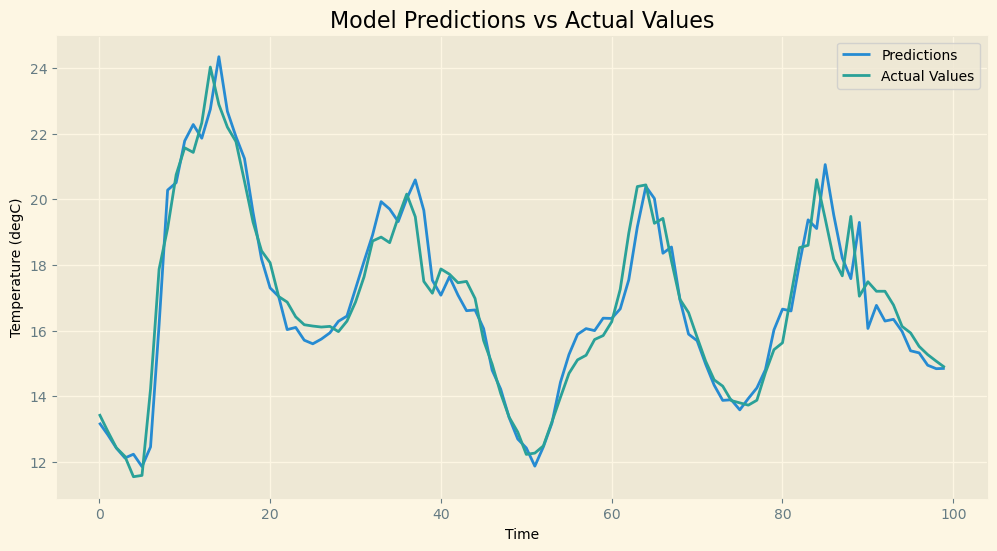

RMSE: 0.682772


(      Predictions  Actual Values
 0       13.194362          13.46
 1       12.826677          12.93
 2       12.421757          12.43
 3       12.121473          12.17
 4       12.235174          11.55
 ...           ...            ...
 5080    -0.991063          -0.98
 5081    -1.358536          -1.40
 5082    -1.744907          -2.75
 5083    -2.985328          -2.89
 5084    -3.177459          -3.93
 
 [5085 rows x 2 columns],
 0.4661782648831228)

In [ ]:
plot_predictions1(model4, X2_test, y2_test)

#### Testing

Upon examining the plot and the corresponding dataframe, it is evident that the predicted values closely align with the actual values, suggesting that the model effectively captures the patterns and trends in the data. The low validation loss of 0.468899 signifies the small average deviation between the predicted and actual values. This successful performance underscores the model's capability to forecast historical weather conditions using multiple variables. Overall, these results demonstrate the effectiveness and accuracy of the model in predicting historical weather patterns.

While I am happy with this model, I next wish to add in the pressure variable as the output or second predicted variable.

159/159 [==============================] - 1s 5ms/step


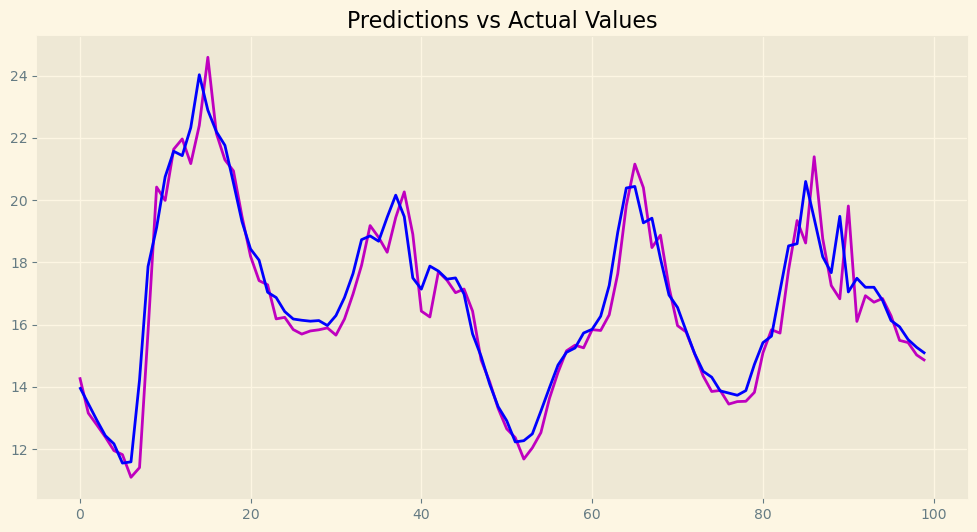

RMSE: 0.8054


(      Predictions  Actual Values
 0       14.307220          13.99
 1       13.156382          13.46
 2       12.776748          12.93
 3       12.385982          12.43
 4       11.951803          12.17
 ...           ...            ...
 5081    -1.157815          -0.98
 5082    -1.434142          -1.40
 5083    -1.638217          -2.75
 5084    -3.321342          -2.89
 5085    -3.163599          -3.93
 
 [5086 rows x 2 columns],
 0.6487158264912273)

In [ ]:
plot_predictions2(model1, X_test, y_test, start=0, end=100)

We can use pandas .hour attribute to get the hour of the day for each index. We can also use other attributes to pull additional data from the index.  To make this cleaner, will create a function called features for our engineering.
   
We will add these as new columns to our dataframe.


In [ ]:

def create_features(df):
    """
    Creates time series features from datetime index
    """
    df = df.copy() # We don't want to modify the original dataframe
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek # Monday=0, Sunday=6
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

AttributeError: 'Index' object has no attribute 'hour'

In [ ]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualizing the Feature / Target Relationship

Text(0.5, 1.0, 'Hourly Boxplot of Energy Consumption (in MWh)')

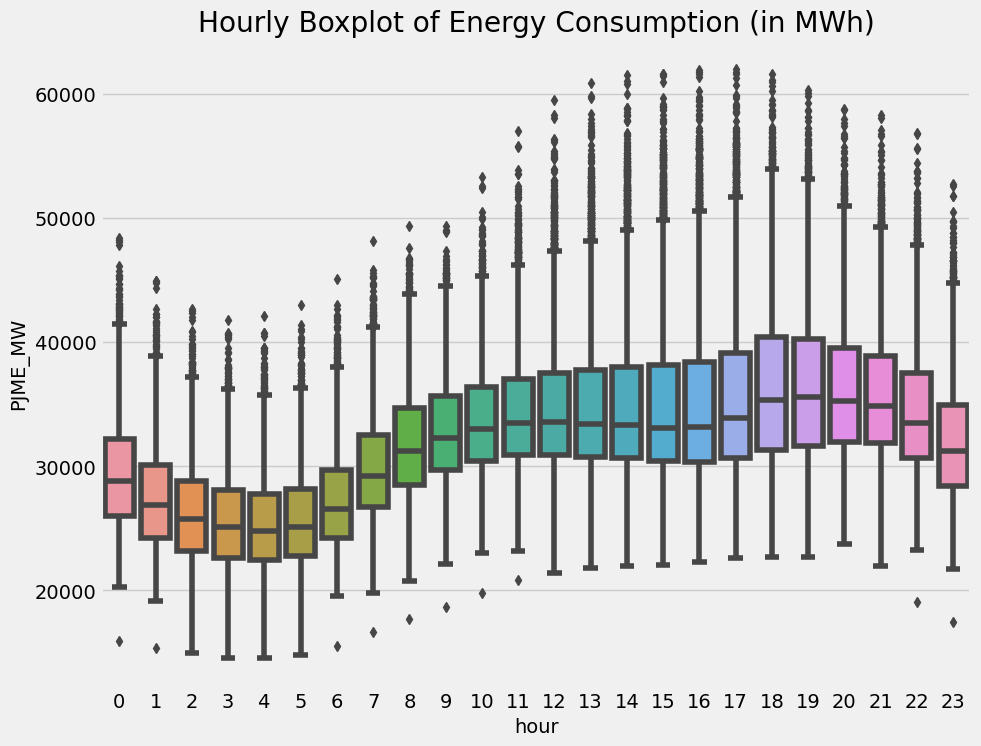

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='hour', y='PJME_MW')
ax.set_title('Hourly Boxplot of Energy Consumption (in MWh)')    # This is a style of plot

We see that early in the morning, there appears to be a dip in energy usage until 5.  It tends to get higher in the evening.

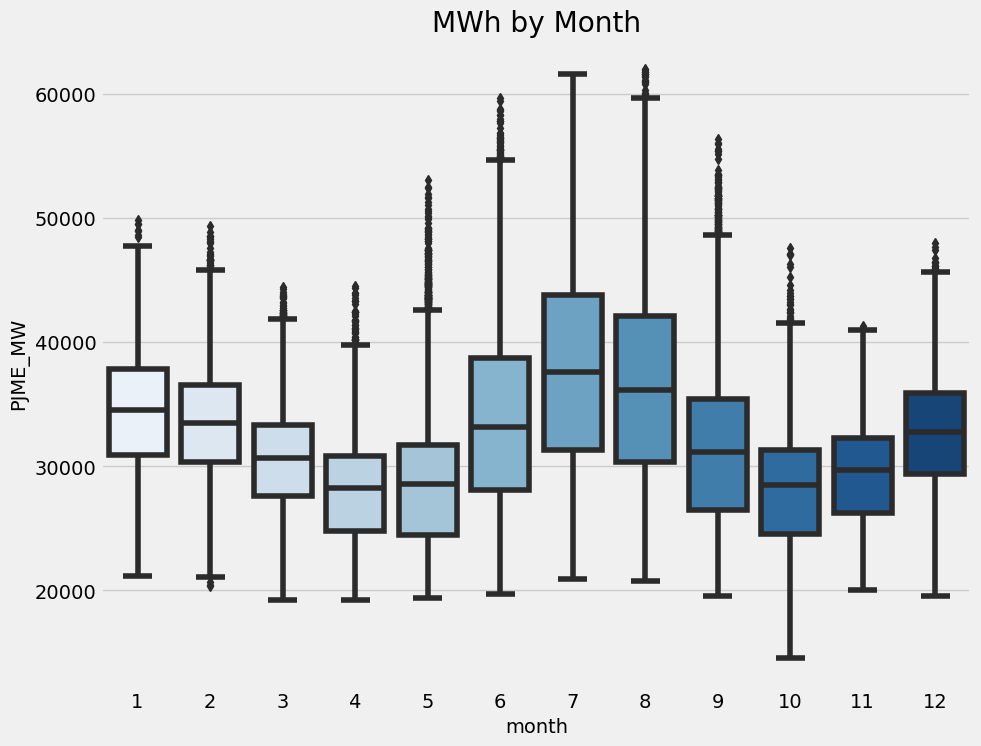

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MWh by Month') 
plt.show()

The MW usage by month tends to peak two times, in the winter season and again in the Summer

In [ ]:
# We need to run the training and testing data through the same features function
train = create_features(train)
test = create_features(test)

In [ ]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [ ]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [ ]:
# we need to drop the target values from the training and testing datasets
# X_train = train.drop('PJME_MW', axis=1) # axis=1 means we are dropping a column instead of a row
# y_train = train['PJME_MW']

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]  



In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.01) 
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        #early_stopping_rounds=50, # Activates early stopping. The model will train until the validation score stops improving.
        verbose=100) # If 'verbose' and an evaluation set is used, writes the evaluation metric measured on the validation set to stderr.

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935


[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[451]	validation_0-rmse:2771.05175	validation_1-rmse:3731.37067


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

The output shows that RMSE goes down through each iteration on the training set. However, the validation on the test set starts to go down but then begins to get worse after 10 iterations.
  
  This is indicative of overfitting with n_estimators=1000.  Another thing we can do is lower the learning rate.

With a learning rate of 0.01, and verbose set to show every 100 trees built.  This stopped at 450 trees because our test or validation set started to get worse after that many trees were built.

## <a id='toc1_9_'></a>[Feature Importance](#toc0_)
This will give us the importance values based on how much these features were used in each of the trees built by the XGBoost model.



In [ ]:
# This is a list of the importance of each feature 
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance'])


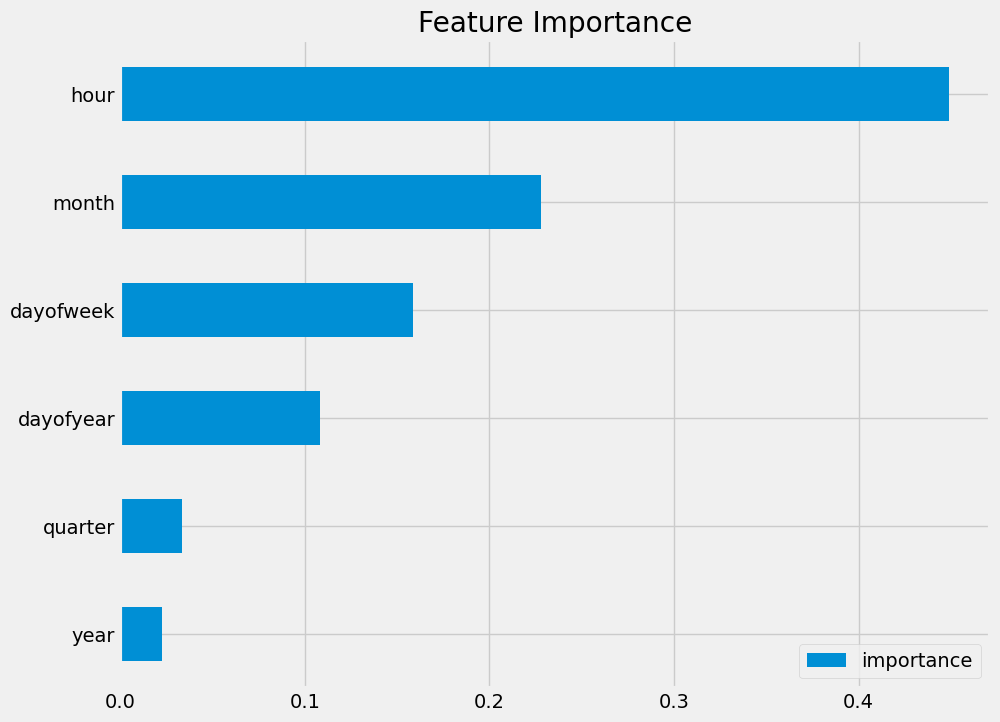

In [ ]:
fi.sort_values(by='importance', ascending=True).plot(kind='barh', 
                                                      title='Feature Importance',
                                                      figsize=(10, 8)) 
plt.show()

Keep in mind that when you have highly correlated features, this feature importance functionality will not tell you exactly how important each feature is individually.

## Forecast on Test Data


In [ ]:
test['prediction'] = reg.predict(X_test)

Now I would like to see these predictions next to all the training data, so we will merge this.

In [ ]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

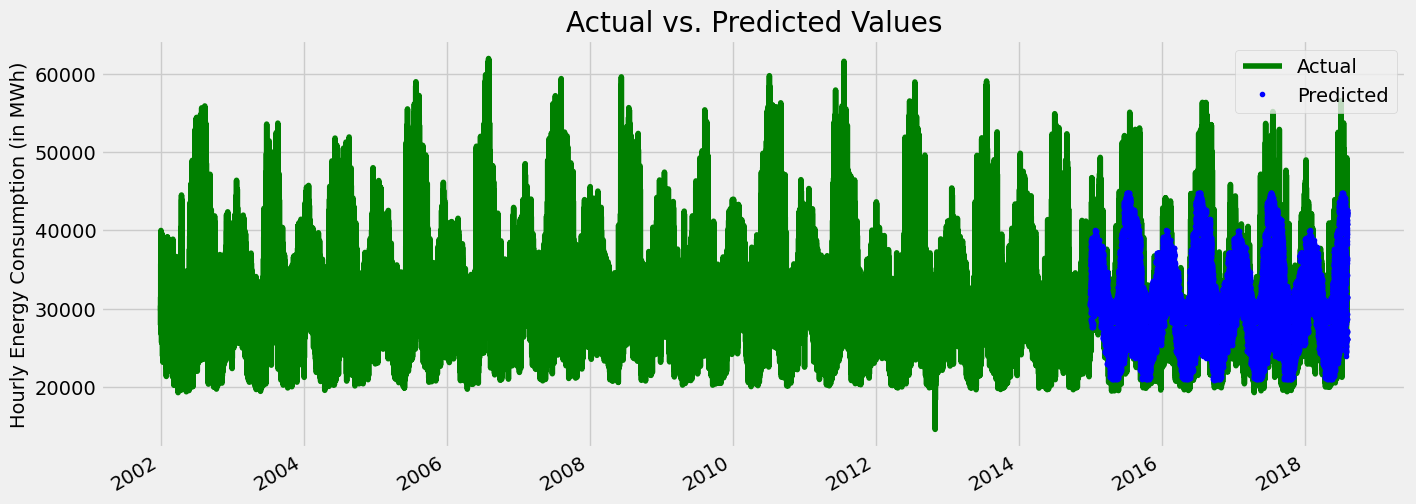

In [ ]:
ax = df[['PJME_MW']].plot(figsize=(15, 6), color='green')
df['prediction'].plot(ax=ax, style='.', color = 'blue')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
ax.set_xlabel('')
plt.show()


Similar to what was done previously, lets look at one week of data to see how the model performed.

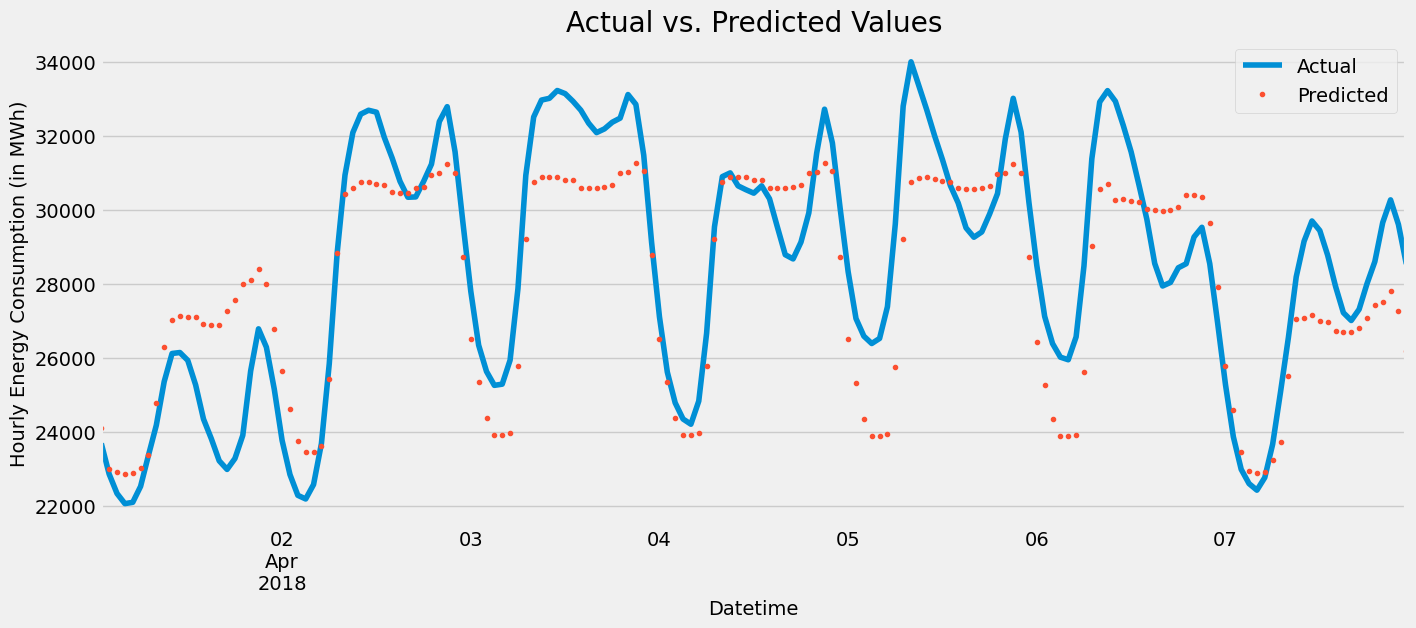

In [ ]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 6), title='A Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
ax.set_title('Actual vs. Predicted Values')
ax.legend(['Actual', 'Predicted'])
ax.set_ylabel('Hourly Energy Consumption (in MWh)')
plt.show()

We can see that the model isnt perfect. There is room for improvement. For example, this could include better parameter tuning.  Also, we could add in features for specific days of the year, like holidays.
    
The predictions do generally follow the trend you would expect to see with the peaks and valleys.

Lastly, we will run the evaluation metric on this

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction'])) # RMSE
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3715.93


### Calculate Error
* Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] -test['prediction'])

In [ ]:
test['date'] = test.index.date

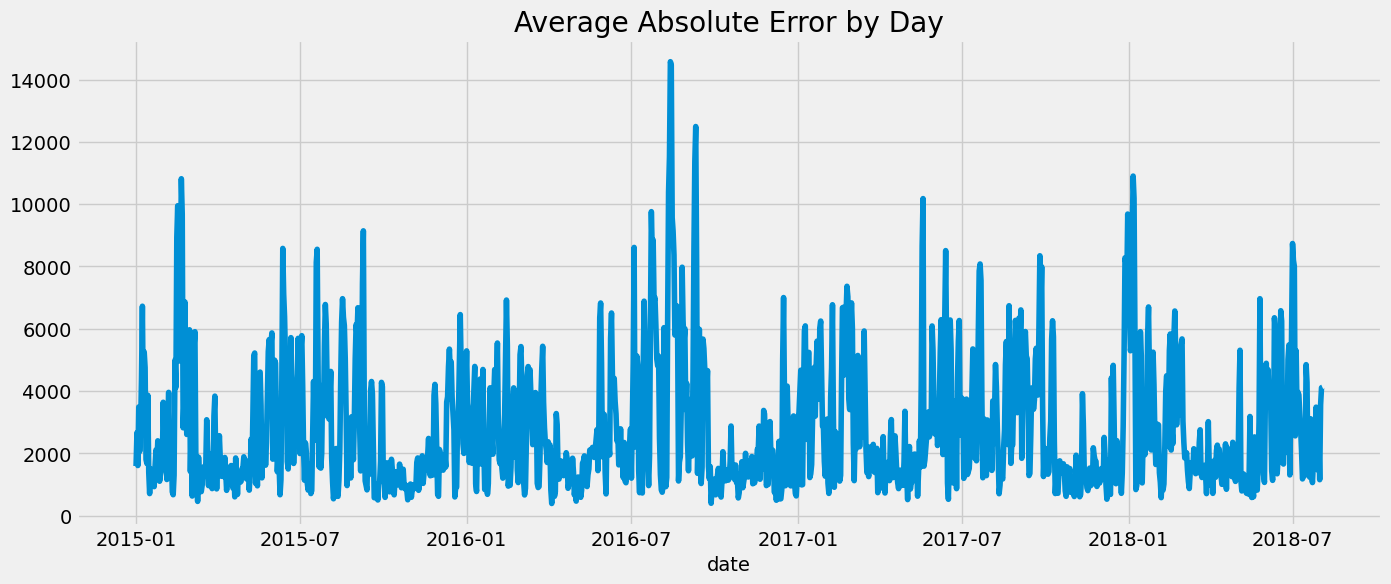

In [ ]:
test.groupby('date')['error'].mean().plot(figsize=(15, 6),  
                                            title='Average Absolute Error by Day')
plt.show()

In [ ]:
test.groupby('date')['error'].mean().sort_values().head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

Some of the best predictions were on days with the lowest average absolute error. These seem to be in 2016. 
  
  Next, Let's take a look at the worst days.

In [ ]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

The worst predicted days all seem to be in the middle of August in 2016

### <a id='toc1_10_2_'></a>[Next Steps:](#toc0_)
- More robust cross-validation
- Add more features (i.e. Weather forecasts, holidays)

# The End